In [1]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.svm import LinearSVC


from datassist import experiment

In [2]:
df_titanic = pd.read_csv('data/train.csv')
df_titanic = df_titanic.set_index('PassengerId')

## Preprocessing Pipeline

In [3]:
params = {
    'random_state': 42,
    'imputer': 'median',
}

In [4]:
# Dropping Name since it is not important for prediction,
# Cabin is also not useful since it has too many missing values.
# Finally, ticket is a random string of characters
X = df_titanic.drop(columns=['Survived', 'Name', 'Cabin', 'Ticket'])
y = df_titanic['Survived']

In [5]:
# Impute missing values
X['Age'] = X['Age'].fillna(X['Age'].median())

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=params['random_state'])

In [7]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
299,1,male,28.00,0,0,30.5000,S
885,3,male,25.00,0,0,7.0500,S
248,2,female,24.00,0,2,14.5000,S
479,3,male,22.00,0,0,7.5208,S
306,1,male,0.92,1,2,151.5500,S


In [8]:
# class InputReshaper(BaseEstimator, TransformerMixin):
#     """Reshape the input to the imputer if 1D to get rid of error"""
#     def __init__(self, imputer) -> None:
#         super().__init__()
#         self.imputer = imputer

#     def fit(self, X, y=None):
#         if X.ndim == 1:
#             self.imputer.fit(X.to_numpy().reshape(-1, 1))
#         else:
#             self.imputer.fit(X)
#         return self
    
#     def transform(self, X, y=None):
#         if X.ndim == 1:
#             return self.imputer.transform(X.to_numpy().reshape(-1, 1))
#         else:
#             return self.imputer.transform(X)

In [9]:
# Feature Engineering
# imputer = InputReshaper(SimpleImputer(strategy=='median'))
numeric_transformer = QuantileTransformer(
    output_distribution='normal',
    random_state=params['random_state'],
    n_quantiles=500
)
categorical_encoder = OneHotEncoder()

# Identify Features
numeric_features = X.drop(columns=['SibSp', 'Parch']).select_dtypes(include='number').columns
categorical_features = X.select_dtypes(include='object').columns

column_transformer = ColumnTransformer(
    [
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_encoder, categorical_features),
    ],
    # SibSp and ParCh will be passed through unchanged since
    # they are omitted from `numeric_features`
    remainder="passthrough",
    n_jobs=-1
)

In [10]:
X_train_processed = column_transformer.fit_transform(X_train)

In [11]:
X_train_processed[0, :]

array([-5.19933758e+00, -2.51165422e-03,  6.79227086e-01,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [12]:
clf = LinearSVC()

## Results

In [13]:
cv_results = experiment.evaluate_cv(clf, X_train_processed, y_train, scoring='f1')
experiment.print_cv_results(cv_results, scoring='F1 score')

CV Results
F1 score: 0.72119 +/- 0.04058
training time: 0.01s +/- 0.00s


In [14]:
clf.fit(X_train_processed, y_train)
X_val_processed = column_transformer.transform(X_val)
y_pred = clf.predict(X_val_processed)

c:\Users\Adam\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Adam\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


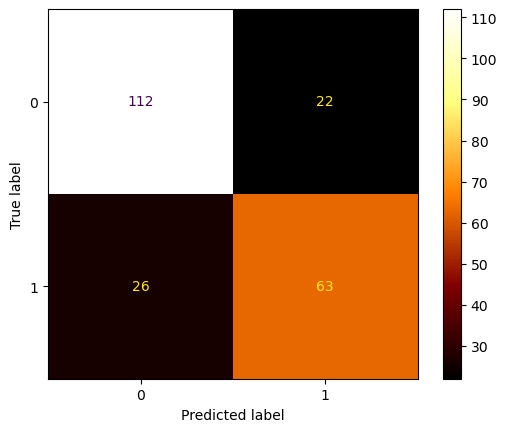

In [15]:
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display.im_.set_cmap('afmhot')

In [16]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       134
           1       0.74      0.71      0.72        89

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223

